### Interview Task


<b> 設計兩個分析問題

>   該問題的目標? 報告對象? 假設? 所需資料?

>   每個問題 “一個” 視覺化圖表 (靜態或動態皆可)

>   為什麼選擇該圖表呈現方式? 所考量的面向為何?


In [7]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from math import cos,pi

import requests
import json
import re

import geopandas
import ipyleaflet
from ipywidgets import HTML

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    GeoData,
    Marker, 
    Popup
)
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
gMapClientKey = ''

from _lib import *

Populating the interactive namespace from numpy and matplotlib


 ## Q1 可以用7-11密集程度當作是未來分行設立的依據嗎？
> 7-11在台灣共有五千餘家分店，多年的發展下，業務相當多元化：從民生必需品零售、物流已至票卷代售等，<br>
其所在地亦象徵一定的商業活動與交通樞紐。可否將7-11視為地區商業的代表，並藉此參考成為未來分行設立的標準呢？

`方法`：此分析將5000個7-11分店作為節點，使用k-means計算出104個中心(同台新分行數量)，觀察k-means中心點的分佈狀況。<br>



`分析目標`：7-11作為地區商業活動代表的可行性？

`報告對象`：分行規劃決策者

`所需資料`：7-11分店經緯度、台新分行經緯度。

`假設`：<br>
>(1) 空間的平均性，沒有交通便捷、地形組閣等問題，距離以直線距離估計。<br>
(2) 現在台新分行分布是分行規劃的最佳解。

`為什麼選擇該圖表呈現方式`: 因為想要呈現的是地理位置資料，將7-11分店位置直接標註於地圖可以一眼看出分布的疏密程度。

`結果`：<br>
>從地圖結果上看來7-11的地理中心點並非理想的分行位置，但在某些7-11聚集性高的地區例如台北、台中、新竹等，<br>k-means的落點和分行的點位有很大的重疊，顯示此方法只適合部分地區。

### Loading and sorting data

In [8]:
# import data
#taishin = pd.read_excel('taishin_branch.xlsx')

In [9]:
################################################################################
#### NEVER run this cell unless needed(google charge for the sevice)!!!!!!  ####
################################################################################
# get geocode for taishin branch

#location = taishin.地址.apply(lambda x: get_googleData(x))
#taishin['location'] = location
#taishin['lat'] = taishin.location.apply(lambda x:x['lat'])
#taishin['lng'] = taishin.location.apply(lambda x:x['lng'])
#taishin.to_csv('taishin_location.csv', index =False)

In [10]:
taishin = pd.read_csv('taishin_location.csv')
#taishin.info()
seven = pd.read_csv('dt_711.tsv', sep = '\t')
#seven.info()

In [11]:
# caculated functions of every 7-11 store 
functions_col = seven.columns[range(10,32)]
seven['function_sum'] = seven[functions_col].apply(lambda x: x=='Y').sum(axis =1)


# extract city
seven['city'] = seven.addr.apply(lambda x:re.match('.*?[市縣]{1}',x).group(0))
taishin['city'] = taishin.地址.apply(lambda x:re.match('.*?[市縣]{1}',x).group(0))

seven['NotAtIsland']=seven.addr.apply(lambda x:findNonIsland(x))
seven['mDis_br']=seven[['lon_x','lat_y']].apply(lambda x: find_closet_branch(taishin, x[0], x[1]), axis=1)  
# calculate the coverage defined by 7-11 stores
# the store not at main island is not included
atIsland = seven[seven['NotAtIsland']==False]


In [12]:
# import city polygon data
city_poly = geopandas.read_file("mapdata201906180930/COUNTY_MOI_1080617.shp")
city_name = pd.read_csv('city_name.tsv', sep='\t')
city_poly.COUNTYNAME = city_name.COUNTYNAME

# import city pop, area disposable income data
city_pop = pd.read_csv('population.csv',usecols=[1,3],header=None,sep='\t')
city_area = pd.read_csv('area.csv',sep='\t',usecols=[1,3],header=None)
city_income = pd.read_csv('income.csv',sep='\t',header=None)
city_hp = pd.read_csv('house_pop.csv',sep='\t',header=None)
city_hp = pd.read_csv('house_pop.csv',sep='\t',header=None)

# merge pop, area, seven_stores, taishin brnaches into geodata
city_pop.columns=['COUNTYNAME','pop']
city_pop['pop']=city_pop["pop"].apply(lambda x:int(x.replace(',','')))

city_area.columns=['COUNTYNAME','area']
city_area.area=city_area["area"].apply(lambda x:float(x.replace(',','')))

city_income.columns=['COUNTYNAME','Disp_inc']
city_income['Disp_inc']=city_income.Disp_inc.apply(lambda x:round(x/1000,2))

city_hp.columns=['COUNTYNAME','hp']

city_poly=city_poly.merge(city_hp,on='COUNTYNAME',how='outer')
city_poly = city_poly.merge(city_income,on='COUNTYNAME',how='outer')
city_poly=city_poly.merge(city_pop,on='COUNTYNAME',)
city_poly=city_poly.merge(city_area,on='COUNTYNAME')

seven['city'] = seven.city.apply(lambda x:x.replace('台','臺'))
seven['city'] = seven.city.apply(lambda x:x.replace('臺東市','臺東縣'))
seven['city'] = seven.city.apply(lambda x:x.replace('屏東市','屏東縣'))
ss=seven.groupby('city').agg({'poiid':'count'}).reset_index()
ss.columns= ['COUNTYNAME','seven_count']
city_poly=city_poly.merge(ss,on='COUNTYNAME',how='outer')

tt=taishin.groupby('city').agg({'分行代碼':'count'}).reset_index()
tt.columns=['COUNTYNAME','br_count']
tt['COUNTYNAME'] = tt.COUNTYNAME.apply(lambda x:x.replace('台','臺'))
city_poly=city_poly.merge(tt,on='COUNTYNAME',how='outer')

city_poly['pop_density'] = city_poly['pop']/city_poly['area']
city_poly['seven_density'] = city_poly['seven_count']/city_poly['area']

city_poly['Disp_incPp'] = city_poly['Disp_inc']/city_poly.hp
#city_poly['total_DispInc'] = city_poly['Disp_inc'] * city_poly['pop']
city_poly.fillna(0,inplace = True)

### visualize
* Use drop down to select data to display as base: `population density` or `average disposable income per person`
* choose the city to show the detail
* And tick the box to choose whether to disply tiahin branches or 7-11 stores or k-means on the map


In [13]:
sdf=atIsland[['poiid', 'lon_x','lat_y','city']]
seven_store = geopandas.GeoDataFrame(
    sdf, geometry=geopandas.points_from_xy(sdf.lon_x, sdf.lat_y))
tdf = taishin[['lng','lat','city']]
taishin_branch = geopandas.GeoDataFrame(
    tdf, geometry=geopandas.points_from_xy(tdf.lng, tdf.lat))

from sklearn.cluster import KMeans


def k_city(city):
    n=taishin[taishin.city==city].shape[0]
    if n==0:
        return None
    seven_location =atIsland[atIsland.city==city][['lon_x','lat_y']]
    kmeans = KMeans(n_clusters=n).fit(seven_location).cluster_centers_
    kk=pd.DataFrame(kmeans)
    kk.columns=[['lng','lat']]
    kdf = geopandas.GeoDataFrame(kk, geometry=geopandas.points_from_xy(kk.lng, kk.lat))
    return kdf


title_dict={"Disposable Income Per Person(k)":'Disp_incPp', 
            "Population Density":'pop_density'}

var_list=title_dict.keys()
city_list = taishin.city.unique()


@interact(base=var_list, city=city_list, tiashin_br=True, seven_st=True,k_means=True)
def plot_poly_var(base, city, tiashin_br, seven_st,k_means):
    fig, ax1= plt.subplots(2,1,figsize=[15,20])
    a=city_poly[city_poly.Disp_incPp!=0]
    base_map = a.plot(column=title_dict[base],ax=ax1[0],cmap='OrRd',legend=True)
    base_map_c = a.plot(column=title_dict[base],ax=ax1[1],cmap='OrRd',legend=True)
    c=seven_store[seven_store.city==city]
    tt= taishin_branch[taishin_branch.city==city]
    buffer_x = (c.lon_x.max()-c.lon_x.min())*0.5
    buffer_y = (c.lat_y.max()-c.lat_y.min())*0.5
    xlim = (c.lon_x.min()-buffer_x,c.lon_x.max()+buffer_x)
    ylim = (c.lat_y.min()-buffer_y,c.lat_y.max()+buffer_y)

    kdf =k_city(city)
    if seven_st:
        seven_store.plot(ax=base_map,marker='o', color='blue', markersize=4,alpha=0.3,label='7-11')
        
        c.plot(ax=base_map_c,marker='o', color='blue', markersize=80,alpha=0.2,label='7-11')
    if tiashin_br:
        taishin_branch.plot(ax=base_map,marker='o', color='#90EE90', markersize=15,alpha=1,label='Taishin')
        tt.plot(ax=base_map_c,marker='o', color='#90EE90', markersize=200,alpha=1,label='Taishin')
    if k_means:
        #kdf.plot(ax=base_map,marker='^', color='black', markersize=15,alpha=0.5,label='K-means')
        if type(kdf)!=type(None):
            kdf.plot(ax=base_map_c,marker='^', color='black', markersize=200,alpha=0.8,label='K-means')

        
    if seven_st or tiashin_br or k_means:
        ax1[1].legend(fontsize=15, markerscale=1,frameon=False)
    ax1[0].set_ylim([21.5,25.5])
    ax1[0].set_xlim([118,123])
    ax1[1].set_ylim(ylim)
    ax1[1].set_xlim(xlim)

    title = "%s"%base
    #tmp=a[['COUNTYNAME', title_dict[var]]].sort_values(title_dict[var],ascending=False)
    
    ax1[0].set_title(title, size=20,pad=20)
    plt.savefig('map1.png')
    plt.show()
    
    
    #display(tmp)


interactive(children=(Dropdown(description='base', options=('Disposable Income Per Person(k)', 'Population Den…

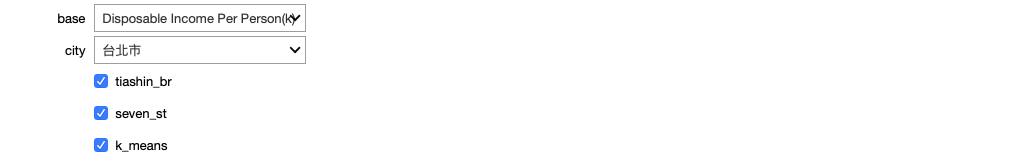

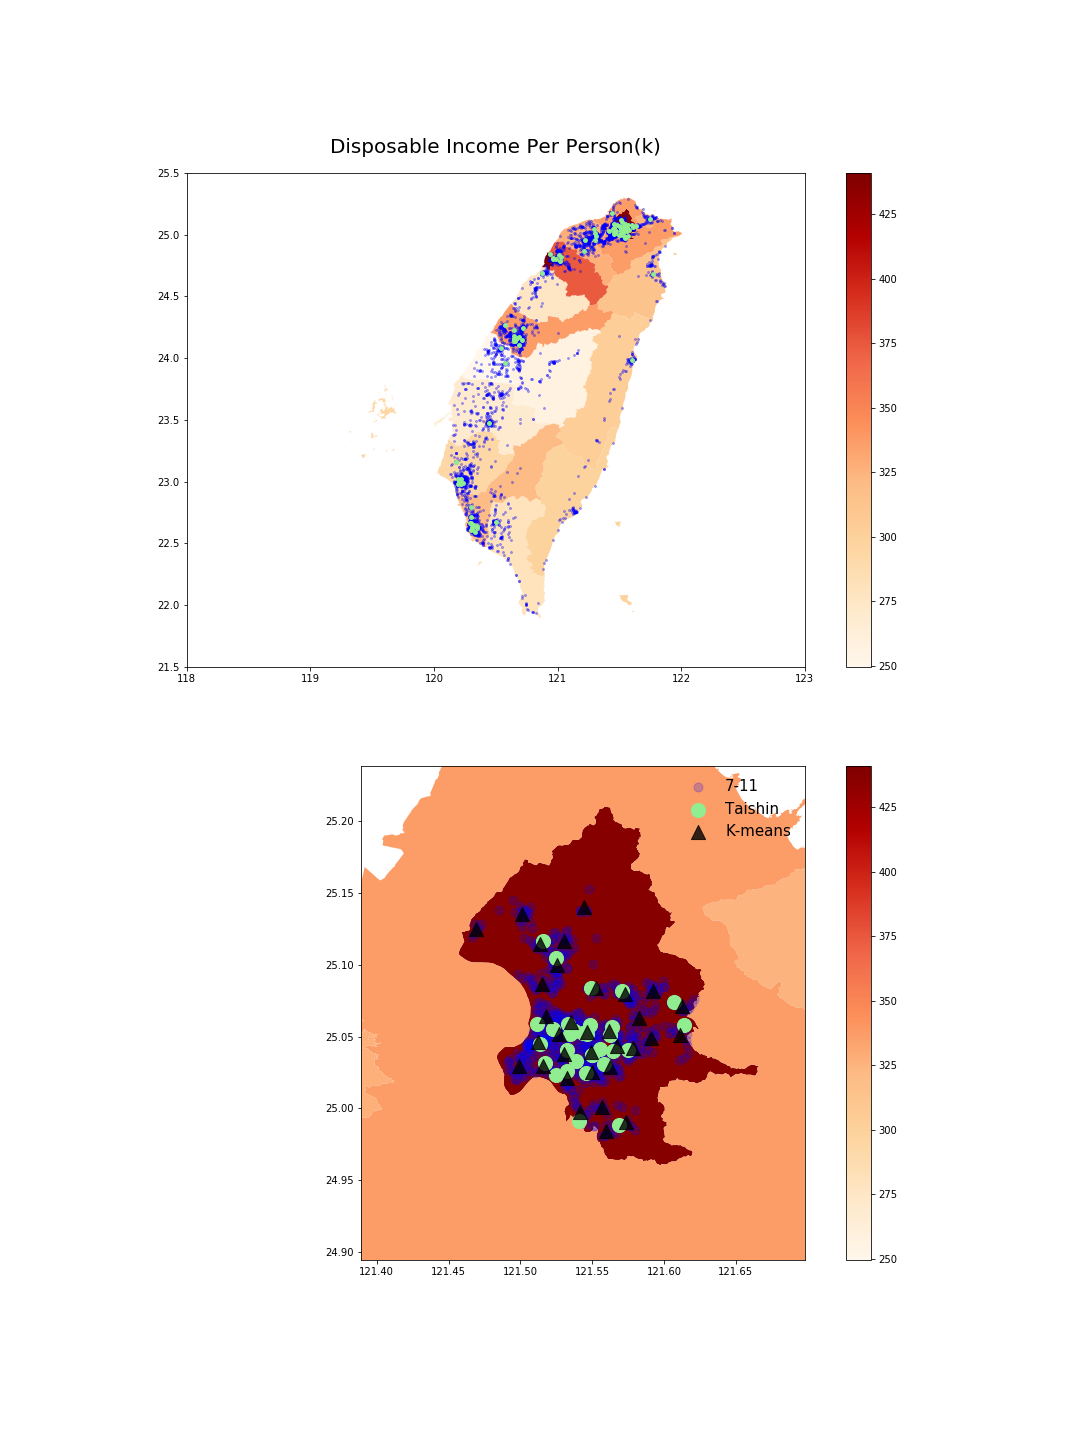

In [25]:
## this is the static image, just in case that image cannot be rendered on github
from IPython.display import Image
display(Image(filename='interactive.png'))
Image(filename='map1.png') 

## Q2: 如果台新要跟7-11合作，減少民眾必須到分行辦理業務的不便，哪個縣市受惠最多？

> 7-11大多數門市有ibon(可執行身份驗證)、影印輸出、傳真與繳費等功能，可以取代部分文書申請工作，<br>且通常距離鄰里相當近，如果可以與其合作，可以減少部分客戶前往分行的次數。

`分析目標`：找出最適合和7-11合作的地區

`報告對象`：各分行經理

`所需資料`：7-11分店經緯度、台新分行經緯度、7-11和最近分行的距離。

`假設`：<br>
> (1) 將7-11視為地區客戶代表，離該間7-11最近的分行會是該間7-11客戶會造訪的分行。<br>
 (2) 與7-11合作會降低客戶跑分行的次數。<br>
 (3) 每一間分行的性質相同。


`為什麼選擇該圖表呈現方式`：
>大小和顏色是顯示距離和數量最常見也最直覺的顯示方式，可以很快的看到最極端的值，<br>
搭配地圖和點選顯示資訊可以方便的獲取地理和更詳細的資訊。


`方法說明`：<br>
>(1) 對`每一7-11尋找離其最近的台新分行`，將該7-11分店歸入該分行。<br>
(2) 計算每間台新分行所有7-11<u>分店數</u>和<u>平均距離</u>，數字越大代表附近民眾要旅行到分行的距離越長。



`結果`：<br>
>* 圖上半徑大且顏色淺的分行代表有相當多地區(7-11)的客戶會到該分行，而且平均旅行距離很長，<br>
* 若使用 `距離*家數` 作為決策指標，前五名的分行為：<b>屏東、嘉義、員林、花蓮、五甲(高雄)</b>。


In [15]:
branch_cover_all = branch_cover(atIsland)

min_lat = atIsland.lat_y.min()
max_lat = atIsland.lat_y.max()
min_long = atIsland.lon_x.min()
max_long = atIsland.lon_x.max()

# the color bar
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

cmap=plt.get_cmap('summer') 
_min = branch_cover_all.poiid['count'].min()
_max = branch_cover_all.poiid['count'].max()


/Users/kimdom/Documents/Apply job/Taishin/_lib.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  branch_cover['Nearest_b_index'] = s.mDis_br.apply(lambda x:x[1])
/Users/kimdom/Documents/Apply job/Taishin/_lib.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  branch_cover['br_distance'] = s.mDis_br.apply(lambda x:x[0])


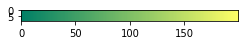

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [16]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 7

m = Map(default_tiles=TileLayer(opacity=0.1), center=center, zoom=zoom, scroll_wheel_zoom=True, 
        layout={'width':'60%', 'height':'600px'})



for br in branch_cover_all.index.values:
    cover_data = branch_cover_all.loc[br]
    br_data = taishin[taishin.分行代碼==br].iloc[0]
    
    _lat = br_data.lat
    _lng = br_data.lng
    _count = cover_data.poiid['count']
    _avg_dis = cover_data.br_distance['mean']
    c=Circle(location=(_lat,_lng), radius=int(500*_avg_dis), weight=1,
            color='#F00', opacity=0.01, fill_opacity=0.8,
            fill_color=get_color(_count))
    m.add_layer(c)
    
    message1 = HTML()
    info = '鄰近7-11數目: %s </br> 平均距離: %s km </br>'%(_count,round(_avg_dis, 3))
    message1.value = info
    message1.placeholder = ''
    message1.description = br_data.名稱
    
    c.popup = message1


figure(figsize=[10,0.2])
ax = plt.subplot(111)
vals=cmap(np.arange(0,1,0.005))[:,:3]
vals3=np.stack([vals]*10)
vals3.shape
ax.imshow(vals3)
plt.show()
m

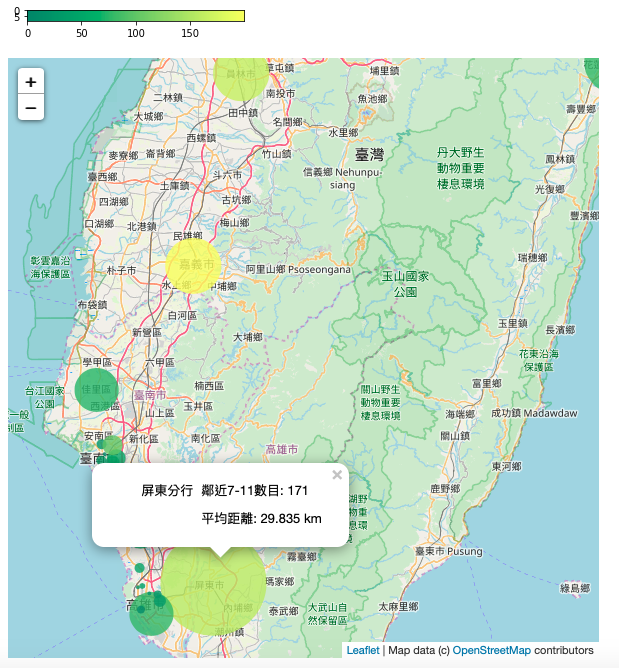

In [17]:
## this is the static image, just in case that image cannot be rendered on github
Image(filename='map2.png') 

In [18]:
branch_cover_all.sort_values('cover',ascending=False).join(taishin[['分行代碼','地址','名稱']].set_index('分行代碼')).head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(poiid, count)","(poiid, unique)","(br_distance, mean)","(cover, )",地址,名稱
Nearest_b_index,,,,,,
30,171,"[120788, 122810, 126513, 153928, 113768, 88220...",29.834754,5101.742981,屏東縣屏東市廣東路103號,屏東分行
21,216,"[131560, 952394, 980045, 881009, 840101, 97065...",15.581319,3365.564840,嘉義市西區垂楊路620號,嘉義分行
104,179,"[998080, 170646, 912112, 902322, 132611, 96907...",15.693463,2809.129926,彰化縣員林市育英路28號,員林分行
23,90,"[126661, 122027, 127125, 972804, 920320, 15525...",17.269500,1554.255041,花蓮縣花蓮市中山路408-9號,花蓮分行
38,88,"[126362, 114233, 922267, 131319, 165080, 99206...",12.491183,1099.224064,高雄市鳳山區五甲二路734號,五甲分行
